## 第4章 顧客の行動を予測する10本ノック

この記事は[「Python実践データ分析100本ノック」](https://www.amazon.co.jp/dp/B07ZSGSN9S/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1)の演習を実際にやってみたという内容になっています。今まで自己流でやってきましたが、一度他の方々がどのような考え方やコーディングをしているのか勉強してみようと思ってやってみました。本書は実際の業務に活用する上でとても参考になる内容だと思っています。データ分析に関わる仕事をしたい方にお勧めしたいです。

本演習で利用しているデータは本サイトからは利用できません。ぜひとも「Python実践データ分析１００本ノック」を購入し、本に沿ってダウンロードして自分の手でコーディングしてみてください。（私は決して回し者ではないので安心してください笑）

結果だけ載せました。正解かどうかは保障しません笑

同じくスポーツジムのデータの例を用いて、クラスタリングや線形回帰など基本的な機械学習手法を実行します。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/ml/data100/04/04_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/ml/data100/04/04_nb.ipynb)

### 筆者の環境

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('pandas version :', pd.__version__)

matplotlib version : 3.0.3
scipy version : 1.4.1
numpy version : 1.16.2
pandas version : 1.0.3


## 解答

### ノック 31 : データを読み込んで確認しよう

In [4]:
uselog = pd.read_csv("use_log.csv")
uselog.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [5]:
customer = pd.read_csv('customer_join.csv')
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


欠損値の個数を確認します。

In [6]:
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [7]:
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### ノック 32 : クラスタリングで顧客をグループ化しよう 

k-meansという手法を用いてクラスタリングを行います。説明変数として、平均や中央値、最大最小値などを利用します。最初にk-meansに利用する変数を持つテーブルを作成します。

In [8]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


実際にk-meanを利用してクラスタリングを実行します。その前に、整数型では標準化の際にwarningが出るので、float型に変換します。

In [9]:
customer_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean               4192 non-null   float64
 1   median             4192 non-null   float64
 2   max                4192 non-null   int64  
 3   min                4192 non-null   int64  
 4   membership_period  4192 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 163.9 KB


In [10]:
customer_clustering = customer_clustering.astype({'max': float, 'min': float, 'membership_period': float})

In [11]:
customer_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean               4192 non-null   float64
 1   median             4192 non-null   float64
 2   max                4192 non-null   float64
 3   min                4192 non-null   float64
 4   membership_period  4192 non-null   float64
dtypes: float64(5)
memory usage: 163.9 KB


となり、型変換が出来ました。

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

customer_clustering_sc

array([[-0.28120614, -0.13367635,  0.08117747, -0.5336197 ,  2.03402524],
       [-0.14054502, -0.13367635, -0.37992814, -0.02114919,  2.03402524],
       [-0.42186727, -0.13367635, -0.84103375, -0.02114919,  2.03402524],
       ...,
       [ 1.50050144,  1.46662237,  0.08117747,  2.54120338, -1.28811491],
       [ 3.18843493,  3.06692109,  1.46449428,  4.07861492, -1.28811491],
       [ 2.62579043,  2.53348819,  1.00338868,  3.56614441, -1.28811491]])

#### sklearnのstandardscalerについて

データの標準化です。与えられた数値のデータを平均0、標準偏差1のガウス分布に変換します。

$ \displaystyle
x = \frac{x - x_{mean}}{\sigma}
$

という変換をしてくれます。

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

data = np.arange(9).reshape(3,3).astype('float64')
print('before : \n',data)

data = sc.fit_transform(data)
print('after : \n', data)

before : 
 [[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
after : 
 [[-1.22474487 -1.22474487 -1.22474487]
 [ 0.          0.          0.        ]
 [ 1.22474487  1.22474487  1.22474487]]


次に実際にクラスタリングしてみます。クラス多数を4に設定します。各クラスタリングに対して0から3のラベルが付与されています。

In [14]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering['cluster'] = clusters.labels_

customer_clustering['cluster'].unique()

array([1, 2, 3, 0], dtype=int32)

In [15]:
customer_clustering.head()

,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8.0,2.0,47.0,1
1,5.083333,5.0,7.0,3.0,47.0,1
2,4.583333,5.0,6.0,3.0,47.0,1
3,4.833333,4.5,7.0,2.0,47.0,1
4,3.916667,4.0,6.0,1.0,47.0,1


### ノック 33 :クラスタリングの結果を分析しよう 

In [16]:
customer_clustering.columns = ['月内平均値', '月内中央値', '月内最大値', '月内最小値', '会員期間', 'cluster']

customer_clustering.groupby('cluster').count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,841,841,841,841,841
1,1248,1248,1248,1248,1248
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [17]:
customer_clustering.groupby('cluster').mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.061076,8.046373,10.015458,6.171225,7.027348
1,4.677436,4.671074,7.233173,2.153045,36.925481
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.537658,5.388889,8.753754,2.702703,14.876126


### ノック 34 : クラスタリングの結果を可視化してみよう

主成分分析により時限削減を行い、可視化してみます。主成分分析（PCA)や次元削減につては機械学習の教科書を参考にしてください。

In [18]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)

x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)

pca_df['cluster'] = customer_clustering['cluster']

In [19]:
# 主成分空間上の行列
x_pca

array([[-0.81998232, -1.95909657],
       [-0.70792183, -1.79985685],
       [-1.06149902, -1.65982605],
       ...,
       [ 3.02793307,  1.13963534],
       [ 6.08311415,  0.58470806],
       [ 5.06472045,  0.76968382]])

In [20]:
# pcs_dfのカラム
pca_df.columns

Index([0, 1, 'cluster'], dtype='object')

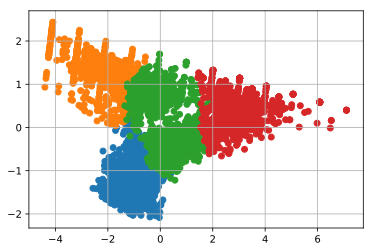

In [21]:
for i in customer_clustering['cluster'].unique():
  tmp = pca_df.loc[pca_df['cluster'] == i]
  plt.scatter(tmp[0], tmp[1])

plt.grid()
plt.show()

綺麗に4次元のデータを2次元に圧縮することが出来ました。素晴らしい。

### ノック 35 : クラスタリングの結果を基に退会顧客の傾向を把握しよう

4つに分けたクラスターの継続顧客と退会顧客の集計を行います。

退会顧客を特定するためにid_deleted列をcustomer/clusteringに追加し、cluster、is_deleted毎に集計を行います。

In [22]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)

In [23]:
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,822
1,0,1,19
2,1,0,1230
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [24]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,789
2,1,0,2
3,1,1,1246
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


### ノック 36 : 翌日の利用回数予測を行うための準備をしよう

教師あり学習の線形回帰の演習になります。

In [28]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['年月'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['年月', 'customer_id'], as_index=False).count()

uselog_months.rename(columns={'log_id':'count'}, inplace=True)

uselog_months.drop(['usedate'], axis=1, inplace=True)
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [32]:
year_months = list(uselog_months['年月'].unique())
predict_data = pd.DataFrame()

# 2018年10月から2019年3月までの半年間
for i in range(6, len(year_months)):
  tmp = uselog_months.loc[uselog_months['年月'] == year_months[i]]
  tmp.rename(columns={'count': 'count_pred'}, inplace=True)

  for j in range(1,7):
    tmp_before = uselog_months.loc[uselog_months['年月'] == year_months[i-j]]
    
    del tmp_before['年月']
    tmp_before.rename(columns={'count': 'count_{}'.format(j-1)}, inplace=True)
    
    tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
  
  predict_data = pd.concat([predict_data, tmp], ignore_index=True)  
  
predict_data.head()

/Users/hiroshi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [33]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)

predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### ノック 37 : 特徴となる変数を付与しよう

In [35]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [36]:
predict_data['now_date'] = pd.to_datetime(predict_data['年月'], format='%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])

from dateutil.relativedelta import relativedelta

predict_data['period'] = None

for i in range(len(predict_data)):
  delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
  predict_data['period'][i] = delta.years * 12 + delta.months
  
predict_data.head()


/Users/hiroshi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### ノック 38 : 来月の利用回数予測モデルを構築しよう

In [41]:
predict_data = predict_data.loc[predict_data['start_date'] >= pd.to_datetime('20180401')]

from sklearn import linear_model
import sklearn.model_selection

model = linear_model.LinearRegression()

X = predict_data[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']]
y = predict_data['count_pred']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [42]:
model.score(X_train, y_train)

0.6050017100677016

In [43]:
model.score(X_test, y_test)

0.6156950883845493

### ノック 39 : モデルに寄与している変数を確認しよう

In [44]:
coef = pd.DataFrame({'feature_names':X.columns, 'coefficient': model.coef_})
coef

,feature_names,coefficient
0,count_0,0.330209
1,count_1,0.195897
2,count_2,0.157352
3,count_3,0.197374
4,count_4,0.075736
5,count_5,0.046952
6,period,0.087706


直近（count_0)の係数が最大となっています。直近の利用回数が高ければ、次の月の利用する傾向があることがわかります。

### ノック 40 : 来月の利用回数を予測しよう

In [45]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [47]:
model.predict(x_pred)

array([3.87532795, 2.05395632])

最後にCSVのデータを保存します。

In [48]:
uselog_months.to_csv('use_og_months.csv', index=False)

## 関連記事
- [第1章 ウェブからの注文数を分析する10本ノック](/ml/data100/01/)
- [第2章 小売店のデータでデータ加工を行う10本ノック](/ml/data100/02/)
- [第3章 顧客の全体像を把握する10本ノック](/ml/data100/03/)
- [第4章 顧客の行動を予測する10本ノック](/ml/data100/04/)
- [第5章 顧客の退会を予測する10本ノック](/ml/data100/05/)
- [第6章 物流の最適ルートをコンサルティングする10本ノック](/ml/data100/06/)
- [第7章 ロジスティクスネットワークの最適設計を行う10本ノック](/ml/data100/07/)
- [第8章 数値シミュレーションで消費者行動を予測する10本ノック](/ml/data100/08/)
- [第9章 潜在顧客を把握するための画像認識10本ノック](/ml/data100/09/)
- [第10章 アンケート分析を行うための自然言語処理10本ノック](/ml/data100/10/)